# iLQR-VAE tutorial 

In this tutorial, we will do the following : 

* Introduce the iLQR-VAE model
* Illustrate the inference procedure in iLQR-VAE on the Maze dataset, using random or pre-trained parameters
* Show examples of how the flexible inference model can be used


## iLQR-VAE overview


iLQR-VAE is a method to infer latent trajectories from noisy time series of observations

It does this by modelling the observations as the output of an *input-driven latent dynamical system*, which latent trajectories are read out onto the observation space. 

The model is trained by optimizing the parameters to maximize the likelihood of the data - essentially, this corresponds to learning the dynamical system that best explains the observations

For a given set of parameters, the latent trajectories are found using **iLQR**, a powerful optimization algorithm which allows to perform inference (i.e to find the latent trajectories that best explain the data given the parameters)

This differs from other similar methods (e.g LFADS) which instead learn the mapping from observation to latents using neural networks 

The main advantages of iLQR-VAE is that it defines the mapping from data to latents *implicitly*, meaning that it has less hyperparameters to tune. This also makies the training more robust, and the inference more flexible (although not that there is no free lunch, and that the inference step in iLQR-VAE is typically slower than in e.g LFADS) 

### Generative process 

iLQR-VAE models observations (here, spike trains) as the output of an input-driven latent dynamical system (similarly to LFADS)


<img src="figures/generative.png" width="70%"/>



**Details of the generative model**
* $\theta$ are the parameters of the model

* $\mathbf{u}_t \in \mathbb{R}^m$, $\mathbf{z}_t \in \mathbb{R}^n$ and $\mathbf{o}_t \in \mathbb{R}^{n_o}$

* Input-driven latent state dynamics : $\mathbf{z}_{t+1} = f_\theta(\mathbf{z}_t, \mathbf{u}_t, t)$

* Likelihood given latents : $\mathbf{o}_t | \mathbf{z}_t \sim p_\theta(\mathbf{o}_t | \mathbf{z}_t)$

* Student prior over the inputs (favouring *sparse inputs*) with a special Gaussian prior for the initial input (setting initial condition)





### Inference procedure
To train the model, we optimize $\theta$ to maximize the marginal log-likelihood of observing a collection of independent observation sequences $\mathbf{\mathcal{O}} = \{ \mathbf{o}^{(1)}, \ldots, \mathbf{o}^{(K)} \}$ (trials) given by:
$$
    \log p_\theta(\mathbf{\mathcal{O}})
    =
    \sum_{k=1}^K
    \log \int
    p_\theta(\mathbf{o}^{(k)} |\mathbf{z}(\mathbf{u}))
    p_\theta(\mathbf{u})\,
    d \mathbf{u}
$$

Unfortunately, computing this expression is intractable. A common approach to deal with this problem is to introduce a new distribution $\log q_\phi(\mathbf{u}|\mathbf{o}^{(k)})$, typically chosen to be Gaussian, to approximate the posterior distribution $p_\theta(\mathbf{u}|\mathbf{o}^{(k)})$. This then allows to write down a lower bound on the log-likelihood, called the ELBO :   
$$\mathcal{L}(\mathbf{\mathcal{O}}, \theta, \phi) =
    \sum_k
    \mathbb{E}_{q_\phi(\mathbf{u}|\mathbf{o}^{(k)})}
    \left [
        \sum_{t=1}^T
        \underbrace{\log p_\theta(\mathbf{o}_t^{(k)} | \mathbf{z}_t)}_{\text{reconstruction term}}
        +
         \underbrace{\log p_\theta(\mathbf{u}_t) - 
         \log q_\phi(\mathbf{u}_t|\mathbf{o}^{(k)}}_{\text{regularization term}} )\right]       \\
        \leq \log p_\theta(\mathbf{\mathcal{O}}).$$

We thus also need an expression for $\log q_\phi(\mathbf{u}_t|\mathbf{o}^{(k)})$ : one common approach is to use a Gaussian approximation parameterized with (bi-)RNNs (as in LFADS). This has the disadvantage that it introduces new (hyper)-parameters into the model. Instead, we define $\log q_\phi(\mathbf{u}_t|\mathbf{o}^{(k)})$ to be centered at the *maximum of the true log posterior* $\mathbf{u}^\star$, defined as :
        
 $$\mathbf{u}^\star(\mathbf{o}^{(k)})
      = \underset{\mathbf{u}}{\text{argmax}}\: \log p_\theta(\mathbf{u}|\mathbf{o}^{(k)}) \\
      = \underset{\mathbf{u}}{\text{argmax}} \left[
        \sum_{t=1}^T \log p_\theta(\mathbf{o}_t^{(k)} | \mathbf{u})
        + \log p_\theta(\mathbf{u}_t)
        \right]$$
    
These inputs are now the solution of an optimization problem, which we solve using **iLQR**, a powerful algorithm from the control literature, such that 
$\mathbf{u}^\star(\mathbf{o}) =
    \text{iLQRsolve}(\mathbf{o}, \theta).$

iLQR solves for the inputs *iteratively* (more details can be found [here](https://jonathan-hui.medium.com/rl-lqr-ilqr-linear-quadratic-regulator-a5de5104c750)), and converges in a few iterations to a local optimum of the log posterior. 
    
This has the advantage that we don't need to introduce new parameters for the inference (at least for the mean), and reduces the number of hyperparameters to optimize. 

### Full model

<img src="figures/model.png" width="70%"/>


* The recognition model is defined *implicitly* through the generative parameters, yielding a compact model

## Illustration of iLQR-VAE on the Maze dataset

### Load the libraries

In [2]:
#use_output "dune top"

open Owl
open Ilqr_vae
open Tutorial_lib
open Gp
open Owl_parameters
open Base
open Vae
include Vae_typ
open Vae_typ.P
open Functions
open Tutorial_vae


let () = print_msg "Libraries loaded successfully!"

module P = Ilqr_vae.Vae_typ.P


Libraries loaded successfully!

### Define the generative model 

When we want to fit a model, we first need to define the generative model : this requires us to specify the prior over inputs, the likelihood function (i.e noise model) and the dynamics of the generator RNN

In [3]:
(*Ocaml is a typed language : here, we define the parameters 
that we will need to pass when setting up the model (number of inputs, number of latents, size of the data)*)
type setup =
  { n : int
  ; m : int
  ; n_trials : int
  ; n_steps : int
  ; n_neural : int
  }

let n = 90
let m = 15
let dt = 5E-3
let n_neurons = 137
let n_beg = n / m
let setup = { n; m; n_trials = 1; n_steps = 140; n_neural = n_neurons }

(*Below, we specify which modules the model will consist of. This corresponds to choosing
the type of Prior/dynamics and likelihood we want to use. 
This structure allows to quickly modify the model (e.g we could use a Gaussian prior, or
a vanilla RNN) by simply swapping one of the modules. *)

(* Define the prior*)
module U = Prior.Student (struct
  let n_beg = n / m
  let m = m
end)

(*Choose the type of likelihood (e.g Poisson for spikes, Gaussian for calcium imaging)*)
module L = Likelihood.Poisson (struct
  let label = "neural"
  let dt = AD.F dt
  let link_function = AD.Maths.exp
  let d_link_function = AD.Maths.exp
  let d2_link_function = AD.Maths.exp
  let n_output = n_neurons
  let n = n
end)

(*Choose the dynamics (e.g GRU RNN)*)
module D = Dynamics.Mini_GRU_IO (struct
  let phi x = AD.Maths.(AD.requad x - F 1.)
  let d_phi x = AD.d_requad x
  let sigma x = AD.Maths.sigmoid x
  let d_sigma x = AD.Maths.(exp (neg x) / sqr (F 1. + exp (neg x)))
  let m = m
  let n = n
  let n_beg = Some (n / m)
end)

(*define the hyperparameters for this dataset : latent space dimension n, number of input channels m *)
module X = struct
  let n = setup.n
  let m = setup.m
  let n_steps = setup.n_steps
  let diag_time_cov = false
  let n_beg = n_beg
end

let () = Jupyter_notebook.clear_output ()

### Define the full model

Next, we need to specify the recognition model. iLQR-VAE's main characteristic is the use of iLQR as an (implicitly defined) recognition model, however we could substitute this with e.g biRNNS, yielding a model similar to LFADS

In [4]:
(*build the full model : this takes in the modules defined above, as well
as the recognition model, and puts them together into the full VAE model.*)
module Make_model
    (U : Prior.T)
    (D : Dynamics.T)
    (L : Likelihood.T) (S : sig
      val n_steps : int
    end) =
struct
  module G = Generative.Make (U) (D) (L)

  (*define the recognition module*)
  module R =
    Recognition.ILQR (U) (D) (L)
      (struct
        let conv_threshold = 1E-6
        let reuse_u = `never
        let diag_time_cov = false
        let n_steps = setup.n_steps
      end)

  module Model = Vae.Make (G) (R)
end

module Model = Make_model (U) (D) (L) (X)

let () = Jupyter_notebook.clear_output ()

let () = print_msg "Model defined successfully!"

Model defined successfully!

### Load the data

Here, we will illustrate the inference procedure of iLQR-VAE on a single trial from the Maze task. The full dataset can be downloaded at https://dandiarchive.org/#/dandiset/000128.

In [5]:
let train_spikes = Arr.load_npy "nlb/train_spikes_0.npy"
let n_train_neurons = 137
let n_test_neurons = 45
let n_neurons = n_train_neurons + n_test_neurons

let trial =
  let open Likelihood.Poisson_P in
  let x =
    Arr.get_slice [ [ 0 ] ] train_spikes |> fun z -> Arr.reshape z [| -1; n_neurons |]
  in
  let o = AD.pack_arr x in
  Data.pack o

let () = Jupyter_notebook.clear_output ()

### Visualize the data 

- Below, we visualize 1 trial (out of 1721 trials used to train the model)

val spikes_to_plot : Owl.Arr.arr = <abstr>


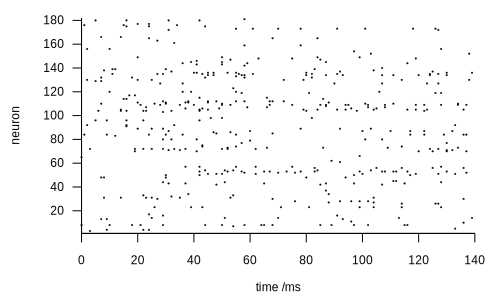

In [6]:
let spikes_to_plot =
  Arr.get_slice [ [ 0 ] ] train_spikes |> fun z -> Arr.reshape z [| -1; n_neurons |]

let () =
  let fig (module P : Plot) =
    P.plots
      (List.init 182 (fun i ->
           let st = "p pt 7 ps 0.2 lc black" in
           let fi = Float.of_int i in
           let arr = Arr.get_slice [ []; [ i ] ] spikes_to_plot in
           let arr = Arr.(fi $* arr) in
           item (A arr) ~style:st))
      (default_props @ [ xlabel "time /ms"; ylabel "neuron"; yrange (1., 182.) ])
  in
  Juplot.draw ~fmt:`svg ~size:(500, 300) fig

## Training the model : 
* We need to learn the **generative** parameters of the model and the **posterior covariance**
* This is done by optimizing the ELBO
* To train the model, we use Adam with a sqrt decaying learning rate
* The learning rate, as well as the size of the latent state and the dimension of the inputs are *hyperparameters which need to be tuned*
* The training is parallelized over CPUs and typically takes ~6-8h on 168 CPUs with a batch size of 168 
* Here, we will show how iLQR works as an inference module, using the parameters of the model at **random initialization**, and contrasting this with results given by a **pre-trained model**

In [7]:
open Model

### Define a function to return the mean firing rates + inputs 

* The following helper function will take in a set of parameters and a data trial, and infers the inputs that best explain those data, as well as the corresponding firing rates

In [8]:
let get_us_and_rates gen_prms prms trial =
  let u_mean, all_us, zs =
    (*to get the posterior mean for a given trial, the model solves for these using iLQR*)
    let u_mean, all_us =
      R.posterior_mean ~gen_prms:prms.generative prms.recognition trial
    in
    let u = AD.Maths.reshape u_mean [| 1; -1; AD.Mat.col_num u_mean |] in
    (*for a given set of inputs, the latents are obtained by running the dynamics forward*)
    let zs = G.integrate ~prms:prms.generative ~u in
    (*we infer the initial condition through the first inputs in the sequence : this 
    means the first time bins of the latent trajectory are meaningless and need to be removed*)
    let remove_n_beg = AD.Maths.get_slice [ []; [ G.n_beg - 1; -1 ] ] in
    remove_n_beg u_mean, all_us, remove_n_beg zs
  in
  let z_mean =
    Arr.mean ~axis:0 (AD.unpack_arr zs)
    |> fun x -> Arr.reshape x [| -1; (Arr.shape x).(2) |]
  in
  let z_mean = AD.pack_arr z_mean in
  let open Vae_typ.P in
  let open Prior_typ in
  let open Generative_typ.P in
  let open Likelihood.Poisson_P in
  (*we generate the firing rates by passing latents through a readout matrix, 
  and passing the whole thing through a nonlinearity, here an exponential function*)
  let c = Owl_parameters.extract gen_prms.generative.likelihood.c in
  let bias = Owl_parameters.extract gen_prms.generative.likelihood.bias in
  let gain = Owl_parameters.extract gen_prms.generative.likelihood.gain in
  AD.Maths.(gain * exp ((z_mean *@ transpose c) + bias)) |> AD.unpack_arr, all_us

let () = Jupyter_notebook.clear_output ()

## Fitting the data with random parameters

* To show the different steps in the inference procedure, we start with the initial parameters of the model (weak and random dynamics, random readout and large standard deviation for the inputs) 

In [9]:
open Generative.P

(*load set of initial random parameters and plot the dynamics/readout*)

let prms = Misc.load_bin "progress_0.params.bin"

val prms : 'a = <poly>


### Plot the initial inferred firing rates

- : Ilqr_vae.AD.A.arr * Ilqr_vae.AD.t list =
(<abstr>,
 [Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>;
  Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>])


val rates : Ilqr_vae.AD.A.arr = <abstr>
val all_us : Ilqr_vae.AD.t list =
  [Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>;
   Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>; Ilqr_vae.AD.Arr <abstr>]


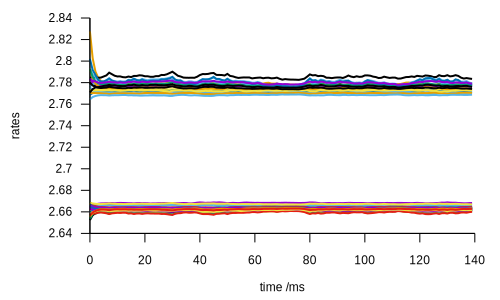

In [10]:
(*perform inference with these initial parameters*)

let _ = get_us_and_rates prms prms trial
let rates, all_us = get_us_and_rates prms prms trial


let () =
  let fig (module P : Plot) =
    P.plots
      (List.init 50 (fun i ->
           let st = Printf.sprintf "l lw 2 lc %i" i in
           item (A (Arr.get_slice [ []; [ 2 * i ] ] rates)) ~style:st))
      (default_props @ [ xlabel "time /ms"; ylabel "rates" ])
  in
  Juplot.draw ~fmt:`svg ~size:(500, 300) fig

With random generative parameters, iLQR-VAE fails to infer meaningful firing rates

### Examine the initial input

iLQR-VAE fits the data by inferring the input that best explains the observations given a set of generative parameters. iLQR solves this problem *iteratively*, by converging in a few iterations to the locally optimal input. Below, we show the evolution of the input over the course of the convergence of iLQR (note that these iterations are different from training iterations, they occur during the inference procedure). 

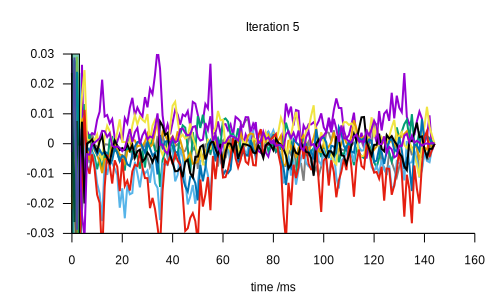

- : unit = ()


In [11]:
let _ =
  let open Gp in
  let display_id = Jupyter_notebook.display "text/html" "" in
  List.iter
    (List.init (List.length all_us) ~f:(fun i -> i))
    (fun phase ->
      Juplot.draw ~fmt:`svg ~size:(500, 300) ~display_id (Functions.plot_us_init all_us phase);
      Unix.sleepf 0.6)

At the beginning of training, the model infers inputs throughout the whole trial to try and infer the data 

## Training procedure 

- below, we will illustrate how to run few training iterations of iLQR 

In [ ]:
(* This is how we would proceed for training*)

open Data

let train_data, test_data =
  let data =
    lazy
      [| Data.pack (AD.pack_arr (Arr.reshape (Arr.load_npy "nlb/train_spikes_0.npy") [|-1;n_neurons|]))
       ; Data.pack (AD.pack_arr (Arr.load_npy "nlb/eval_spikes_in_0.npy"))
      |]
  in
  Data.split_and_distribute ~reuse:false ~prefix:"data" ~train:1 data



let final_prms =
Model.train
    ~n_posterior_samples:(fun iter -> 1)
    ~max_iter:1
    ~learning_rate:(`of_iter (fun k -> Float.(0.004 / (1. + sqrt (of_int k / 1.)))))
    ~init_prms:prms
    train_data

val train_data : ([ `o ], Ilqr_vae.AD.t) Ilqr_vae.Data.t Base.Array.t =
  [|<abstr>|]
val test_data : ([ `o ], Ilqr_vae.AD.t) Ilqr_vae.Data.t Base.Array.t =
  [|<abstr>|]


## After training 

- now we will assume we had time to run 3500 iterations, and repeat the inference procedure with the parameters of the model *after training*. We will load parameters of the model after 3500 iterations, and evaluate the inferred firing rates and inputs. 

In [ ]:
let prms = Misc.load_bin "progress_3500.params.bin"
let rates, all_us = get_us_and_rates prms prms trial


### Inferring the firing rates 

In [ ]:
let () =
  let fig (module P : Plot) =
    P.plots
      (List.init 50 (fun i ->
           let st = Printf.sprintf "l lw 2 lc %i" i in
           item (A (Arr.get_slice [ []; [ 2 * i ] ] rates)) ~style:st))
      (default_props @ [ xlabel "time /ms"; ylabel "rates" ])
  in
  Juplot.draw ~fmt:`svg ~size:(500, 300) fig

After training, the firing rates look a lot more reasonable - to evaluate quantitatively how well the model captures the observations, we will compute co-smoothing below.


### Plotting the input

In [ ]:
let plot_us_fin all_us i (module P : Plot) =
  let it_title = Printf.sprintf "Iteration %i" i in
  let u = List.nth_exn all_us i in
  let u = AD.unpack_arr u |> fun z -> Arr.reshape z [| -1; 15 |] in
  P.plots
    (List.init 10 (fun i ->
         let st = Printf.sprintf "l lw 2 lc %i" i in
         item (A (Arr.get_slice [ []; [ i ] ] u)) ~style:st))
    (default_props
    @ [ xlabel "time /ms"; ylabel ""; title it_title; yrange (-0.1, 0.1) ]
    @ [ set "object rect from 0,-0.1 to 6,0.1 fc lt 2 fs transparent solid 0.3 front" ])

let _ =
  let open Gp in
  let display_id = Jupyter_notebook.display "text/html" "" in
  List.iter
    (List.init (List.length all_us) ~f:(fun i -> i))
    (fun phase ->
      Juplot.draw ~fmt:`svg ~size:(500, 300) ~display_id (plot_us_fin all_us phase);
      Unix.sleepf 0.3)

Interestingly, the trained model relies *only on the initial condition* to fit the observations. This happens despite iLQR-VAE assuming input-driven dynamics by default, suggesting that with this choice of generative model, the "best model" is one evolving autonomously from the initial condition.

### Flexible co-smoothing

* A key advantage of iLQR-VAE is the flexibility of its inference model

* Given a set of generative parameters, inference can be performed on heterogeneous data

* This allows to evaluate co-smoothing (predictions of held-out spikes from held-in data) straightforwardly. We train the model on all the neurons, but at test time we evaluate the same model on a subset of held-in neurons by using **a subset of the readout matrix** to get the latents, and then predict firing rates for all neurons using the **full readout**


<img src="figures/co_smoothing_training.png" width="70%"/>

<img src="figures/co_smoothing_testing.png" width="70%"/>


In [ ]:
(*here, we load a new trial for evaluation of the model : the model will only be shown the held-in spikes, but it 
will make predictions for the firing rates of the whole population*)

let eval_spikes_in = Arr.load_npy "nlb/eval_spikes_in_0.npy"
let eval_spikes_out = Arr.load_npy "nlb/eval_spikes_out_0.npy"
let n_neurons_eval = (Arr.shape eval_spikes_in).(2)

let test_trial =
  let open Likelihood.Poisson_P in
  let x =
    Arr.get_slice [ [ 0 ] ] eval_spikes_in
    |> fun z -> Arr.reshape z [| -1; n_train_neurons |]
  in
  let o = AD.pack_arr x in
  Data.pack o

(*select only the readout parameters of the held-in neurons*)

let masked_prms =
  let masked_likelihood ~prms =
    let open Vae_typ.P in
    let open Prior_typ in
    let open Generative_typ.P in
    let open Likelihood.Poisson_P in
    let c = Owl_parameters.extract prms.c in
    let bias = Owl_parameters.extract prms.bias in
    let gain = Owl_parameters.extract prms.gain in
    Likelihood.Poisson_P.
      { c = pinned (AD.Maths.get_slice [ [ 0; n_train_neurons - 1 ] ] c)
      ; bias = pinned (AD.Maths.get_slice [ []; [ 0; n_train_neurons - 1 ] ] bias)
      ; c_mask = None
      ; gain = pinned (AD.Maths.get_slice [ []; [ 0; n_train_neurons - 1 ] ] gain)
      }
  in
  { generative =
      { prior = prms.generative.prior
      ; dynamics = prms.generative.dynamics
      ; likelihood = masked_likelihood ~prms:prms.generative.likelihood
      }
  ; recognition = prms.recognition
  }

let rates, all_us = get_us_and_rates prms masked_prms test_trial

let () = Jupyter_notebook.clear_output ()

In [ ]:
let () =
  let fig (module P : Plot) =
    P.plots
      (List.init 45 (fun i ->
           let st = Printf.sprintf "l lw 2 lc %i" i in
           item (A (Arr.get_slice [ []; [ 137 + i ] ] rates)) ~style:st))
      (default_props @ [ xlabel "time /ms"; ylabel "heldout neurons rates" ])
  in
  Juplot.draw ~fmt:`svg ~size:(500, 300) fig

let () =
  let spikes_to_plot =
    Arr.get_slice [ [ 0 ] ] eval_spikes_out
    |> fun z -> Arr.reshape z [| -1; n_test_neurons |]
  in
  let fig (module P : Plot) =
    P.plots
      (List.init 45 (fun i ->
           let st = Printf.sprintf "p pt 7 ps 0.4 lc %i" i in
           let fi = Float.of_int i in
           let arr = Arr.get_slice [ []; [ i ] ] spikes_to_plot in
           let arr = Arr.(fi $* arr) in
           item (A arr) ~style:st))
      (default_props @ [ xlabel "time /ms"; ylabel "heldout neurons"; yrange (0., 45.) ])
  in
  Juplot.draw ~fmt:`svg ~size:(500, 300) fig

To evaluate co-smoothing quantitatively, we can then compute how much better the model predicts observed spikes than a baseline that models each firing rate as the average rate for that neuron. 
Over the whole validation set (1/574 trials here), iLQR-VAE yields a co-smoothing of 0.354, suggesting that it captures the dynamics very well after learning.

### Flexible inference on heterogeneous time series

* The flexible inference model can also be used to fit *longer* or *shorter trials* than the data it was trained on

* This is different from biRNNs which need to take in data sequences from the same length as the ones they were trained on

* Below, we illustrate this by fitting the model using the whole time series, the first 100ms of the trial, and the first 50ms only

In [ ]:
(*take only the first 50ms of the evaluation data *)
let train_spikes_short_1 = train_spikes |> fun z -> Arr.get_slice [ [ 0 ]; [ 0; -1 ] ] z
let train_spikes_short_2 = train_spikes |> fun z -> Arr.get_slice [ [ 0 ]; [ 0; 99 ] ] z
let train_spikes_short_3 = train_spikes |> fun z -> Arr.get_slice [ [ 0 ]; [ 0; 49 ] ] z

let test_trial_short_1, test_trial_short_2, test_trial_short_3 =
  let open Likelihood.Poisson_P in
  let x = train_spikes_short_1 |> fun z -> Arr.reshape z [| -1; n_neurons |] in
  let o = AD.pack_arr x in
  let x2 = train_spikes_short_2 |> fun z -> Arr.reshape z [| -1; n_neurons |] in
  let o2 = AD.pack_arr x2 in
  let x3 = train_spikes_short_3 |> fun z -> Arr.reshape z [| -1; n_neurons |] in
  let o3 = AD.pack_arr x3 in
  Data.pack o, Data.pack o2, Data.pack o3

module R1 =
  Recognition.ILQR (U) (D) (L)
    (struct
      let conv_threshold = 1E-6
      let reuse_u = `never
      let diag_time_cov = false
      let n_steps = (Arr.shape train_spikes_short_1).(1)
    end)

module R2 =
  Recognition.ILQR (U) (D) (L)
    (struct
      let conv_threshold = 1E-6
      let reuse_u = `never
      let diag_time_cov = false
      let n_steps = (Arr.shape train_spikes_short_2).(1)
    end)

module R3 =
  Recognition.ILQR (U) (D) (L)
    (struct
      let conv_threshold = 1E-6
      let reuse_u = `never
      let diag_time_cov = false
      let n_steps = (Arr.shape train_spikes_short_3).(1)
    end)

let rates test_trial_short num =
  let u_mean, all_us, zs =
    let u_mean, all_us =
      if num = 1
      then R1.posterior_mean ~gen_prms:prms.generative prms.recognition test_trial_short
      else if num = 2
      then R2.posterior_mean ~gen_prms:prms.generative prms.recognition test_trial_short
      else R3.posterior_mean ~gen_prms:prms.generative prms.recognition test_trial_short
    in
    let u = AD.Maths.reshape u_mean [| 1; -1; AD.Mat.col_num u_mean |] in
    let zs = G.integrate ~prms:prms.generative ~u in
    let remove_n_beg = AD.Maths.get_slice [ []; [ G.n_beg - 1; -1 ] ] in
    remove_n_beg u_mean, all_us, remove_n_beg zs
  in
  let z_mean =
    Arr.mean ~axis:0 (AD.unpack_arr zs)
    |> fun x -> Arr.reshape x [| -1; (Arr.shape x).(2) |]
  in
  let z_mean = AD.pack_arr z_mean in
  let open Vae_typ.P in
  let open Prior_typ in
  let open Generative_typ.P in
  let open Likelihood.Poisson_P in
  let c = Owl_parameters.extract prms.generative.likelihood.c in
  let bias = Owl_parameters.extract prms.generative.likelihood.bias in
  let gain = Owl_parameters.extract prms.generative.likelihood.gain in
  AD.Maths.(gain * exp ((z_mean *@ transpose c) + bias)) |> AD.unpack_arr

let rates1, rates2, rates3 =
  rates test_trial_short_1 1, rates test_trial_short_2 2, rates test_trial_short_2 3

let () = Jupyter_notebook.clear_output ()

In [ ]:
let () =
  let fig (module P : Plot) =
    P.plots
      (List.init 30 (fun i ->
           if i < 10
           then (
             let st = Printf.sprintf "l lw 2 lc %i" i in
             item (A (Arr.get_slice [ []; [ 2 * i ] ] rates1)) ~style:st)
           else if i < 20
           then (
             let st = Printf.sprintf "l lw 2 lc %i dt 2" Int.(i - 10) in
             item (A (Arr.get_slice [ []; [ (2 * Int.(i - 10)) ] ] rates2)) ~style:st)
           else (
             let st = Printf.sprintf "l lw 2 lc %i dt 3" Int.(i - 20) in
             item (A (Arr.get_slice [ []; [ (2 * Int.(i - 20)) ] ] rates3)) ~style:st)))
      (default_props @ [ xlabel "time /ms"; ylabel "rates" ])
  in
  Juplot.draw ~fmt:`svg ~size:(500, 300) fig

The inferred rates are similar for the different time windows used. In general, one would expect the inferred rates to be more accurate for larger time windows, as more information is available to find the firing rates.


We've reached the end of the tutorial! 

In summary : 
* iLQR-VAE is a method that models noisy observations as the output of an input-driven dynamical system
* unlike other methods (e.g LFADS) it uses an implicit, optimization-based recognition model, allowing for flexible inference and robust training
* here, we have looked more closely at how the inference procedure works, and shown that iLQR-VAE fits the neural recordings from the Maze dataset very well (here, measured using the co-smoothing metric)
* finally, we have shown how iLQR-VAE can be used on heterogeneous data

Thanks for following through! More details on the method can be found at in [the paper](https://www.biorxiv.org/content/10.1101/2021.10.07.463540v1.article-metrics) and I'm happy to answer further questions [by email](mailto:mmcs3@cam.ac.uk).